In [1]:
from models import VariationalAutoencoder, Autoencoder, ConvAutoencoder, ConvVAE, MyModel
from data_utils import CustomImageDataset
import torch
import os
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from utils import test

plt.style.use("ggplot")

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

Using device: cuda


In [3]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

In [4]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.CenterCrop(28),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0), std=(1))])

## Test

### data

In [5]:
test_data_path = "./homework_2_dataset/dataset/test"
test_dataset = CustomImageDataset(os.path.join(test_data_path, "annotation.txt"), os.path.join(test_data_path, "imgs"), transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

### AE

In [93]:
ae = Autoencoder(16).to(device) # GPU
ae.load_state_dict(torch.load("./autoencoders/AE"))
ae.eval()

Autoencoder(
  (encoder): Encoder(
    (linear1): Linear(in_features=2352, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2352, bias=True)
  )
)

In [94]:
losses = []
true = []
for x, y in test_dataloader:
    true.append(int(y[0]))
    x = x.to(device) # GPU
    reconstruction = ae(x)
    loss = ((x - reconstruction)**2).sum()
    losses.append(loss.item())

In [95]:
thresolds, tp_rate, tn_rate = [], [], []
best_tresholds = []
for thresh in range(10, 80, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 10):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 10)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))
    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        best_tresholds.append(thresh / 10)
    print(f"threshold = {(thresh / 10):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}")

if len(best_tresholds) > 0:
    print(f"best thresholds: {best_tresholds}")

threshold = 1.00: True Positive Rate: 1.00, True Negative Rate: 0.01
threshold = 1.10: True Positive Rate: 1.00, True Negative Rate: 0.02
threshold = 1.20: True Positive Rate: 1.00, True Negative Rate: 0.04
threshold = 1.30: True Positive Rate: 1.00, True Negative Rate: 0.08
threshold = 1.40: True Positive Rate: 1.00, True Negative Rate: 0.12
threshold = 1.50: True Positive Rate: 1.00, True Negative Rate: 0.16
threshold = 1.60: True Positive Rate: 1.00, True Negative Rate: 0.21
threshold = 1.70: True Positive Rate: 1.00, True Negative Rate: 0.25
threshold = 1.80: True Positive Rate: 1.00, True Negative Rate: 0.29
threshold = 1.90: True Positive Rate: 1.00, True Negative Rate: 0.34
threshold = 2.00: True Positive Rate: 1.00, True Negative Rate: 0.39
threshold = 2.10: True Positive Rate: 1.00, True Negative Rate: 0.43
threshold = 2.20: True Positive Rate: 1.00, True Negative Rate: 0.46
threshold = 2.30: True Positive Rate: 1.00, True Negative Rate: 0.50
threshold = 2.40: True Positive Ra

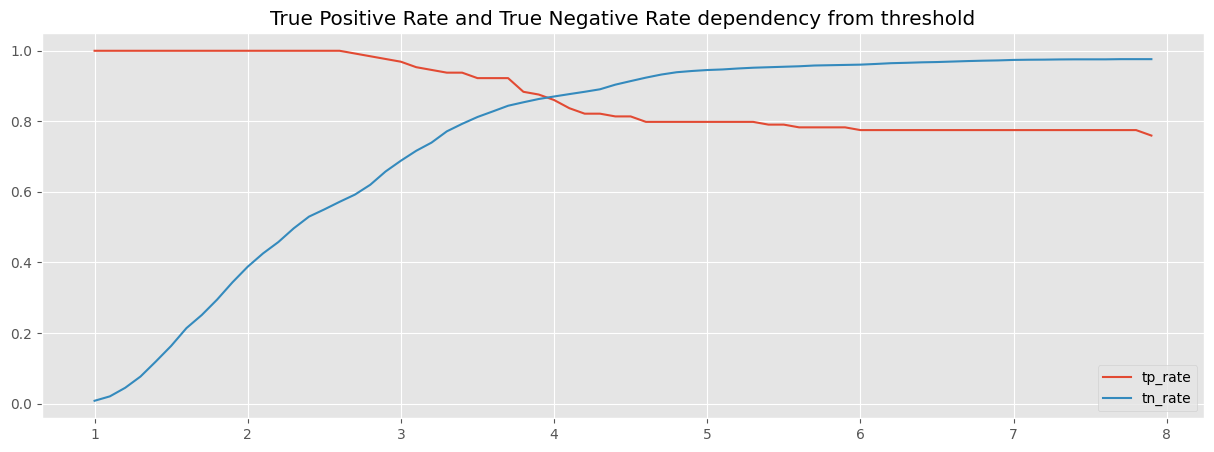

In [96]:
plt.figure(figsize=(15, 5))
plt.plot(thresolds, tp_rate, label = "tp_rate") 
plt.plot(thresolds, tn_rate, label = "tn_rate") 
plt.legend()
plt.title("True Positive Rate and True Negative Rate dependency from threshold")
plt.show()

C:\Users\yxtag\AppData\Local\Temp\ipykernel_5260\1900868561.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')


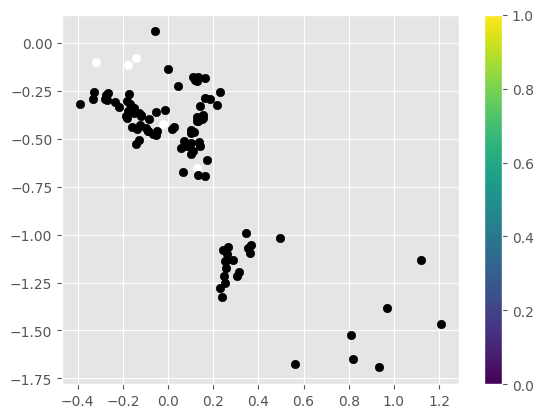

In [97]:
plot_latent(ae, test_dataloader, num_batches=100)

### VAE

In [98]:
vae = VariationalAutoencoder(16).to(device) # GPU
vae.load_state_dict(torch.load("./autoencoders/VAE"))
vae.eval()

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (linear1): Linear(in_features=2352, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=16, bias=True)
    (linear3): Linear(in_features=512, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (linear1): Linear(in_features=16, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=2352, bias=True)
  )
)

In [99]:
losses = []
true = []
for x, y in test_dataloader:
    true.append(int(y[0]))
    x = x.to(device) # GPU
    reconstruction = vae(x)
    loss = ((x - reconstruction)**2).sum() + vae.encoder.kl
    losses.append(loss.item())

In [100]:
thresolds, tp_rate, tn_rate = [], [], []
best_tresholds = []
for thresh in range(10, 2000, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 10):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 10)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))
    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        best_tresholds.append(thresh / 10)
    print(f"threshold = {(thresh / 10):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}")

if len(best_tresholds) > 0:
    print(f"best thresholds: {best_tresholds}")

threshold = 1.00: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.10: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.20: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.30: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.40: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.50: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.60: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.70: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.80: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 1.90: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 2.00: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 2.10: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 2.20: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 2.30: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 2.40: True Positive Ra

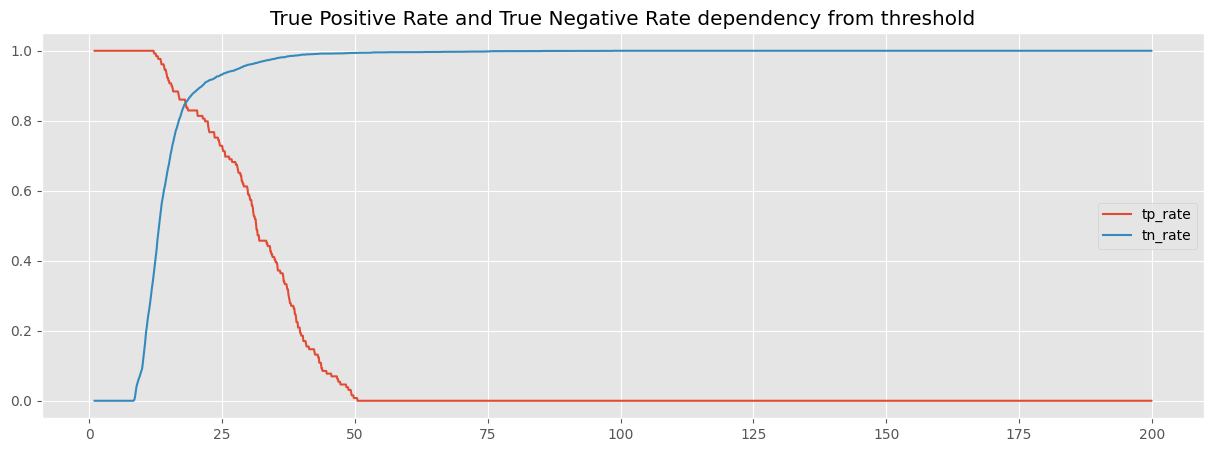

In [101]:
plt.figure(figsize=(15, 5))
plt.plot(thresolds, tp_rate, label = "tp_rate") 
plt.plot(thresolds, tn_rate, label = "tn_rate") 
plt.legend()
plt.title("True Positive Rate and True Negative Rate dependency from threshold")
plt.show()

C:\Users\yxtag\AppData\Local\Temp\ipykernel_5260\1900868561.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')


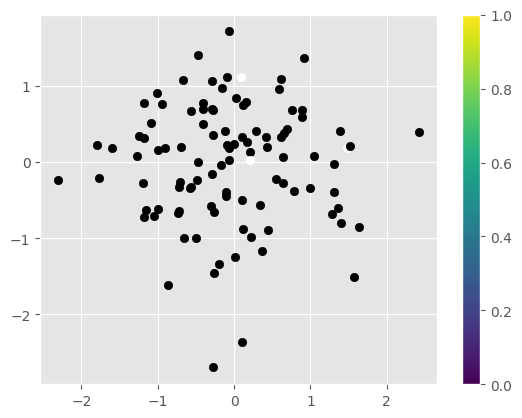

In [102]:
plot_latent(vae, test_dataloader, num_batches=100)

### convolutional AE

In [103]:
conv = ConvAutoencoder().to(device) # GPU
conv.load_state_dict(torch.load("./autoencoders/conv_ae"))
conv.eval()

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [104]:
losses = []
true = []
for x, y in test_dataloader:
    true.append(int(y[0]))
    x = x.to(device) # GPU
    reconstruction = conv(x)
    loss = ((x - reconstruction)**2).sum()
    losses.append(loss.item())

In [105]:
thresolds, tp_rate, tn_rate = [], [], []
best_tresholds = []
for thresh in range(10, 200, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 10):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 10)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))
    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        best_tresholds.append(thresh / 10)
    print(f"threshold = {(thresh / 10):.2f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}")

if len(best_tresholds) > 0:
    print(f"best thresholds: {best_tresholds}")

threshold = 1.00: True Positive Rate: 1.00, True Negative Rate: 0.21
threshold = 1.10: True Positive Rate: 0.99, True Negative Rate: 0.37
threshold = 1.20: True Positive Rate: 0.98, True Negative Rate: 0.51
threshold = 1.30: True Positive Rate: 0.97, True Negative Rate: 0.62
threshold = 1.40: True Positive Rate: 0.95, True Negative Rate: 0.72
threshold = 1.50: True Positive Rate: 0.93, True Negative Rate: 0.79
threshold = 1.60: True Positive Rate: 0.92, True Negative Rate: 0.84
threshold = 1.70: True Positive Rate: 0.91, True Negative Rate: 0.87
threshold = 1.80: True Positive Rate: 0.91, True Negative Rate: 0.91
threshold = 1.90: True Positive Rate: 0.89, True Negative Rate: 0.94
threshold = 2.00: True Positive Rate: 0.87, True Negative Rate: 0.96
threshold = 2.10: True Positive Rate: 0.87, True Negative Rate: 0.97
threshold = 2.20: True Positive Rate: 0.84, True Negative Rate: 0.97
threshold = 2.30: True Positive Rate: 0.81, True Negative Rate: 0.97
threshold = 2.40: True Positive Ra

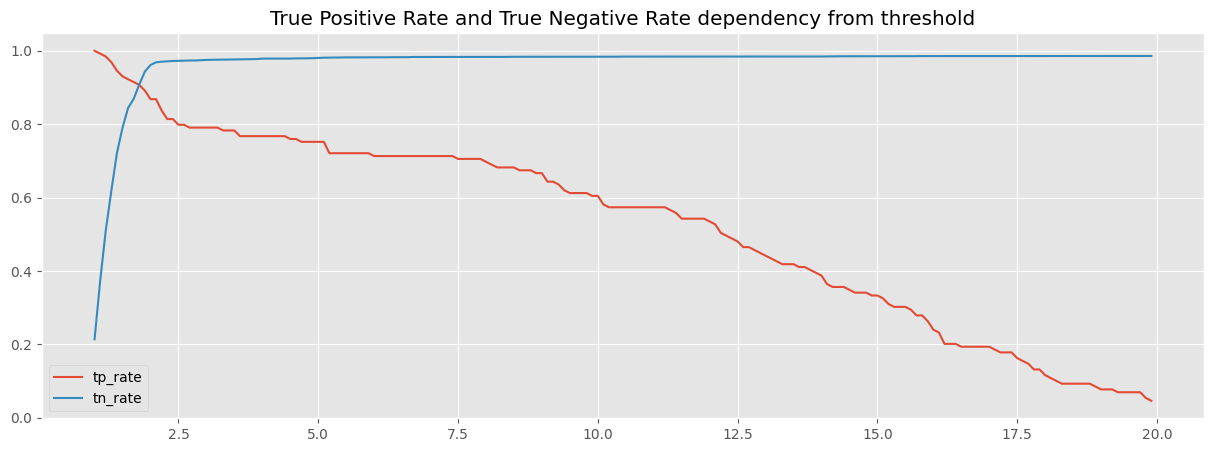

In [106]:
plt.figure(figsize=(15, 5))
plt.plot(thresolds, tp_rate, label = "tp_rate") 
plt.plot(thresolds, tn_rate, label = "tn_rate") 
plt.legend()
plt.title("True Positive Rate and True Negative Rate dependency from threshold")
plt.show()

### convolutional VAE

In [14]:
conv_vae = ConvVAE().to(device) # GPU
conv_vae.load_state_dict(torch.load("./autoencoders/conv_vae"))
conv_vae.eval()

ConvVAE(
  (criterion): MSELoss()
  (Encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
  )
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  

In [15]:
losses = []
true = []
for x, y in test_dataloader:
    true.append(int(y[0]))
    x = x.to(device) # GPU
    reconstruction, mu, logvar = conv_vae(x)
    loss = conv_vae.loss(reconstruction, mu, logvar, x)
    losses.append(loss.item())

In [17]:
thresolds, tp_rate, tn_rate = [], [], []
best_tresholds = []
for thresh in range(0, 150, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 1000):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 1000)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))
    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        best_tresholds.append(thresh / 1000)
    print(f"threshold = {(thresh / 1000):.3f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}")

if len(best_tresholds) > 0:
    print(f"best thresholds: {best_tresholds}")

threshold = 0.000: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.001: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.002: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.003: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.004: True Positive Rate: 0.99, True Negative Rate: 0.01
threshold = 0.005: True Positive Rate: 0.97, True Negative Rate: 0.01
threshold = 0.006: True Positive Rate: 0.95, True Negative Rate: 0.01
threshold = 0.007: True Positive Rate: 0.92, True Negative Rate: 0.02
threshold = 0.008: True Positive Rate: 0.88, True Negative Rate: 0.02
threshold = 0.009: True Positive Rate: 0.83, True Negative Rate: 0.03
threshold = 0.010: True Positive Rate: 0.80, True Negative Rate: 0.06
threshold = 0.011: True Positive Rate: 0.78, True Negative Rate: 0.10
threshold = 0.012: True Positive Rate: 0.77, True Negative Rate: 0.12
threshold = 0.013: True Positive Rate: 0.76, True Negative Rate: 0.14
threshold = 0.014: T

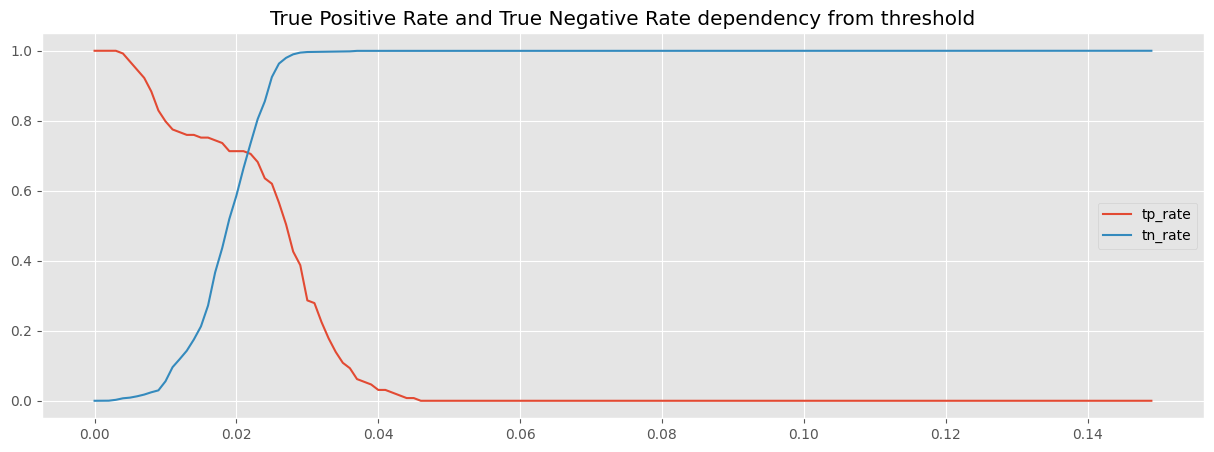

In [18]:
plt.figure(figsize=(15, 5))
plt.plot(thresolds, tp_rate, label = "tp_rate") 
plt.plot(thresolds, tn_rate, label = "tn_rate") 
plt.legend()
plt.title("True Positive Rate and True Negative Rate dependency from threshold")
plt.show()

C:\Users\yxtag\AppData\Local\Temp\ipykernel_20396\1900868561.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')


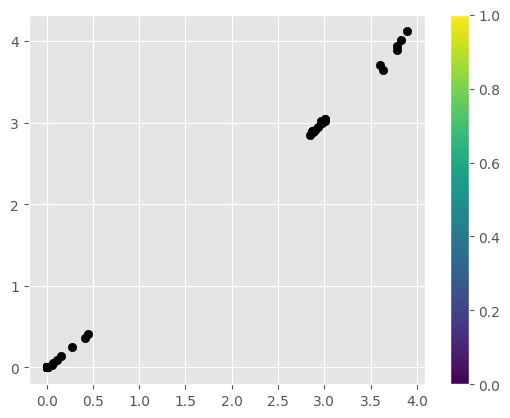

In [19]:
plot_latent(conv_vae, test_dataloader, num_batches=100)

### MyModel

In [6]:
mm = MyModel().to(device) # GPU
mm.load_state_dict(torch.load("./autoencoders/my_model"))
mm.eval()

MyModel(
  (criterion): MSELoss()
  (Encoder): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Linear(in_features=1176, out_features=512, bias=True)
  (fc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc_log_var): Linear(in_features=512, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1176, bias=True)
  (Decoder): Sequential(
    (0): Linear(in_features=1176, out_features=2352, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
losses = []
true = []
for x, y in test_dataloader:
    true.append(int(y[0]))
    x = x.to(device) # GPU
    reconstruction, mu, logvar = mm(x)
    loss = mm.loss(reconstruction, x)
    losses.append(loss.item())

In [8]:
thresolds, tp_rate, tn_rate = [], [], []
best_tresholds = []
for thresh in range(0, 100, 1):
    tp, fp, tn, fn = 0, 0, 0, 0
    for loss, y in zip(losses, true):
        if loss >= (thresh / 10000):
            y_pred = 1
        else:
            y_pred = 0
        
        if y == 1 and y_pred == 1:
            tp += 1
        elif y == 1 and y_pred == 0:
            fn += 1
        elif y == 0 and y_pred == 1:
            fp += 1
        elif y == 0 and y_pred == 0:
            tn += 1
    
    thresolds.append(thresh / 10000)
    tp_rate.append(tp / (tp + fn))
    tn_rate.append(tn / (tn + fp))
    if tp / (tp + fn) > 0.91 and tn / (tn + fp) > 0.91:
        best_tresholds.append(thresh / 10000)
    print(f"threshold = {(thresh / 10000):.4f}: True Positive Rate: {(tp / (tp + fn)):.2f}, True Negative Rate: {(tn / (tn + fp)):.2f}")

if len(best_tresholds) > 0:
    print(f"best thresholds: {best_tresholds}")

threshold = 0.0000: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.0001: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.0002: True Positive Rate: 1.00, True Negative Rate: 0.00
threshold = 0.0003: True Positive Rate: 1.00, True Negative Rate: 0.01
threshold = 0.0004: True Positive Rate: 1.00, True Negative Rate: 0.04
threshold = 0.0005: True Positive Rate: 1.00, True Negative Rate: 0.12
threshold = 0.0006: True Positive Rate: 1.00, True Negative Rate: 0.21
threshold = 0.0007: True Positive Rate: 1.00, True Negative Rate: 0.33
threshold = 0.0008: True Positive Rate: 1.00, True Negative Rate: 0.42
threshold = 0.0009: True Positive Rate: 0.98, True Negative Rate: 0.48
threshold = 0.0010: True Positive Rate: 0.98, True Negative Rate: 0.57
threshold = 0.0011: True Positive Rate: 0.98, True Negative Rate: 0.67
threshold = 0.0012: True Positive Rate: 0.98, True Negative Rate: 0.75
threshold = 0.0013: True Positive Rate: 0.98, True Negative Rate: 0.81
thresh

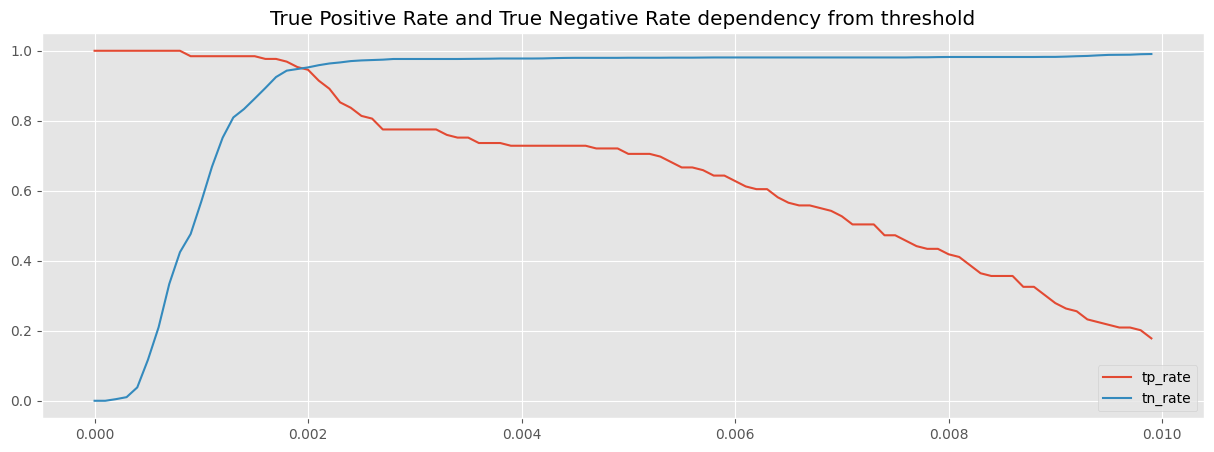

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(thresolds, tp_rate, label = "tp_rate") 
plt.plot(thresolds, tn_rate, label = "tn_rate") 
plt.legend()
plt.title("True Positive Rate and True Negative Rate dependency from threshold")
plt.show()

C:\Users\yxtag\AppData\Local\Temp\ipykernel_20396\1900868561.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')


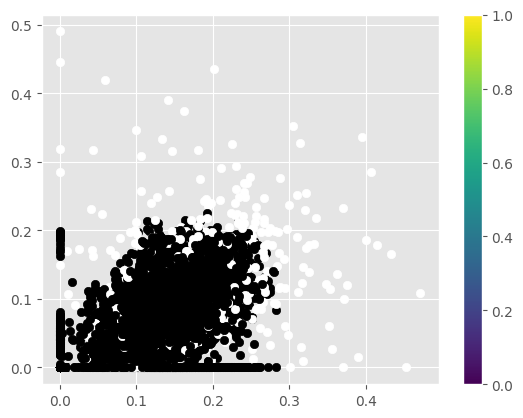

In [10]:
plot_latent(mm, test_dataloader, num_batches=100)